In [2]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD, Adagrad, Adadelta
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
import os

In [4]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 20       # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
PATH_OF_DATA= '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [32]:
import pathlib
!mkdir -p PATH_OF_DATA
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(PATH_OF_DATA, origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [7]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

ahead  back  eyes_closed  eyes_open  glasses_off  glasses_on


In [ ]:
 !tar -xvzf '/content/gdrive/MyDrive/Curso-Jetson/imagenes/flower_photos.tar.gz' -C '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [34]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

ahead  back  eyes_closed  eyes_open  glasses_off  glasses_on


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 359 files belonging to 6 classes.
Using 288 files for training.
Found 359 files belonging to 6 classes.
Using 71 files for validation.


In [9]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Vamos a visualizar una de las muestras y la clase a la que pertenece:

5


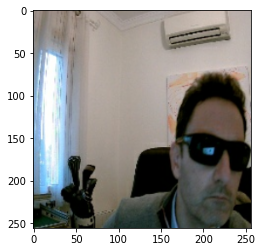

In [28]:
import matplotlib.pyplot as plt
sample = list(train_ds.as_numpy_iterator())[0]    # Tupla con el batch
image = sample[0]                                 # Batch de imagenes
label = sample[1]                                 # Batch de labels
plt.imshow(np.squeeze(image[0])/255.0)
print(label[0])

In [38]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    image=tf.image.resize (image, [224,224])
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [39]:
# Create a pretrained model.
model = tf.keras.applications.MobileNet(
  include_top=False, weights='imagenet', input_shape=(224,224,3), classes=6)

#Freeze weights
for l in model.layers:
  l.trainable=False

# Add new classification layer
flat = tf.keras.layers.Flatten()(model.output)
out = tf.keras.layers.Dense(6, activation='softmax')(flat)

model = tf.keras.models.Model(inputs=model.inputs, outputs=out)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [40]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 3s 146ms/step - loss: 10.0395 - accuracy: 0.4023 - val_loss: 3.5151 - val_accuracy: 0.7324
Epoch 2/20
9/9 [==============================] - 1s 92ms/step - loss: 1.7376 - accuracy: 0.8265 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 3/20
9/9 [==============================] - 1s 94ms/step - loss: 0.1988 - accuracy: 0.9813 - val_loss: 1.1395e-04 - val_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 1s 91ms/step - loss: 0.0046 - accuracy: 0.9973 - val_loss: 0.1522 - val_accuracy: 0.9859
Epoch 5/20
9/9 [==============================] - 1s 93ms/step - loss: 0.0226 - accuracy: 0.9958 - val_loss: 0.0678 - val_accuracy: 0.9859
Epoch 6/20
9/9 [==============================] - 1s 91ms/step - loss: 2.3211e-05 - accuracy: 1.0000 - val_loss: 1.9812e-07 - val_accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 1s 93ms/step - loss: 1.4458e-06 - accuracy: 1.0000 - val_loss: 4.3654e-08 - val_accuracy: 1.0000
Epoch

In [41]:
model.evaluate(val_ds)

3/3 [==============================] - 0s 43ms/step - loss: 2.6864e-08 - accuracy: 1.0000


[2.6864050539643358e-08, 1.0]

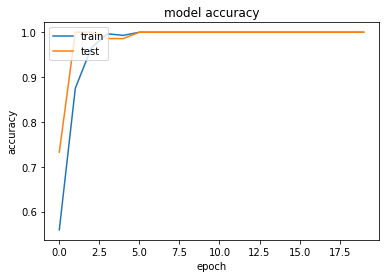

In [42]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

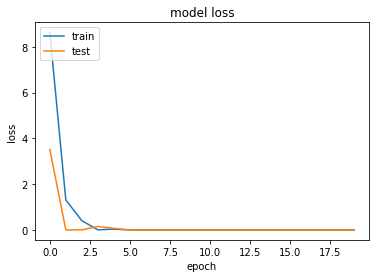

In [43]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model_AVA.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model_AVA'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model_AVA/assets


In [45]:
!ls $OUT_MODEL_PATH

model_AVA  model_AVA.hdf5
